<!-- Notebook Header Start -->

<h1 align="center">Spike Sorting</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-11-18<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---

## 📜 Project Overview

(to populate) 

- **Objective:** (to populate)
- **Scope:** (to populate)

---

## 📊 Notebook Outline

1. **Data Import & Preprocessing**


---

## 📚 References & Additional Resources

- [Kilosort4](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# Importing Libraries & Data
---

### imports

In [1]:
# standard imports
from pathlib import Path
import os
import pandas as pd
import numpy as np
from kilosort import io

# custom imports
from automations import RM1
from automations import kilosort_wrapper

### filepath definitions

In [2]:
# Parameters
RAT_ID = 'DW333'
STIMULATION = 'VF_DRG_1_241115_145435'
SAVE_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
DATA_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)
PROBE_DIRECTORY = Path(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.001 Kilosort on DW322\A1x32-Edge-5mm-20-177-A32.prb')

### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

In [3]:
channel_mapping = pd.read_excel("Adapter_pinout.xlsx",sheet_name="summary",header=2).iloc[:,[8,10,12,14]]
channel_mapping.head(5)

,A1x32 Probe.1,A32->O32 Adapter.1,Intan Board,Intan Input.1
0,32,32,T13,19
1,31,30,T14,20
2,30,31,B13,28
3,29,28,T15,21
4,28,29,B14,27


In [4]:
DW322 = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, RAT_ID)

Reading qsttest_1_241115_150618...
Reading qsttest_1_241115_151239...
Reading qsttest_1_241115_151523...
Reading qst_1_241115_152031...
Reading qst_1_241115_152346...
Reading qst_1_241115_152800...
Reading VF_DRG_1_241115_145120...
Reading VF_DRG_1_241115_145435...
Reading VF_DRG_1_241115_145739...
Reading VF_DRG_4_241115_153512...
Reading VF_DRG_4_241115_170440...
Error recording nerve cuff data for qsttest_1_241115_150618
Error recording nerve cuff data for qsttest_1_241115_151239
Error recording nerve cuff data for qsttest_1_241115_151523
Error recording nerve cuff data for qst_1_241115_152031
Error recording nerve cuff data for qst_1_241115_152346
Error recording nerve cuff data for qst_1_241115_152800
Error recording nerve cuff data for VF_DRG_1_241115_145120
Error recording nerve cuff data for VF_DRG_1_241115_145435
Error recording nerve cuff data for VF_DRG_1_241115_145739
Error recording nerve cuff data for VF_DRG_4_241115_153512
Error recording emg data for qsttest_1_241115_15

In [5]:
# for example, pulling the amp data from the 7th DRGS trial
DW322.mat_files_dict["VF_DRG__145435"]["AM"]["amp"][0, 0][0, 0]

30

In [5]:
DW322.qst_experiment_notes

'd1 is ttl, d2 am sync, a1 am monitor, a2 e von frey'

In [7]:
DW322.drgs_trial_notes.head()

5,Trial Number,Condition,amp (uA),PW (us),Freq. (Hz),Dur. (s),Stimuli,Stage,Stimuli Dur.,rcrtrange,waitime
Trial Number,,,,,,,,,,,
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing Data

### first I must process it for import into Kilosort

I will use a combination of `SpikeInterface` & `Kilosort.io.extractors` to get the data I need

In [6]:
analysis = kilosort_wrapper(DW322, SAVE_DIRECTORY)

running kilosort wrapper for rat DW333


In [9]:
# analysis.save_spinalcord_data_to_binary(TRIAL_NAMES=["VF_DRG_1_241115_145435",
#                                                      "VF_DRG_1_241115_145435",
#                                                      "VF_DRG_1_241115_145739",
#                                                      "VF_DRG_4_241115_153512",
#                                                      "VF_DRG_4_241115_170440",
#                                                      ])
analysis.save_spinalcord_data_to_binary()

Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qsttest_1_241115_150618\DW333_qsttest_1_241115_150618_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qsttest_1_241115_151239\DW333_qsttest_1_241115_151239_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qsttest_1_241115_151523\DW333_qsttest_1_241115_151523_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qst_1_241115_152031\DW333_qst_1_241115_152031_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qst_1_241115_152346\DW333_qst_1_241115_152346_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qst_1_241115_152800\DW333_qst_1_241115_152800_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\VF_DRG_1_

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64


kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qsttest_1_241115_150618\DW333_qsttest_1_241115_150618_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------


|
|
|
|
|
|
Running kilosort on qsttest_1_241115_150618
|
|
|
|
|
|


kilosort.run_kilosort: N samples: 3324672
kilosort.run_kilosort: N seconds: 110.8224
kilosort.run_kilosort: N batches: 56
kilosort.run_kilosort: Preprocessing filters computed in  0.38s; total  0.38s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    13.50 %
kilosort.run_kilosort: Memory:       44.37 %     |     21.27   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   14.22 %     |      1.14   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     1.47 %     |      0.12   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Comp

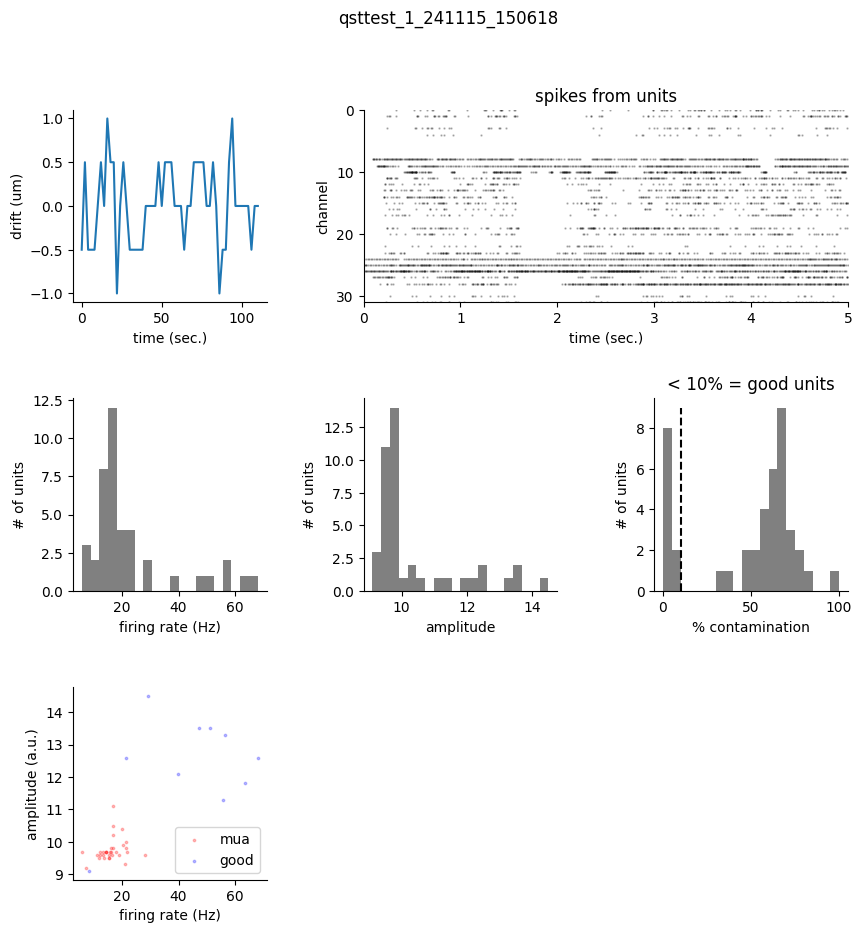

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qsttest_1_241115_150618


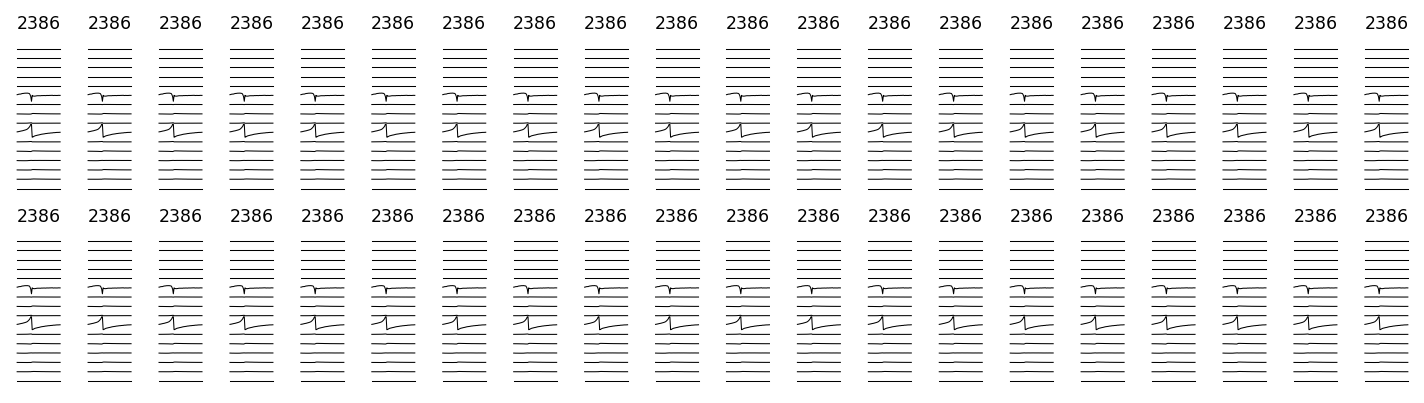

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qsttest_1_241115_150618


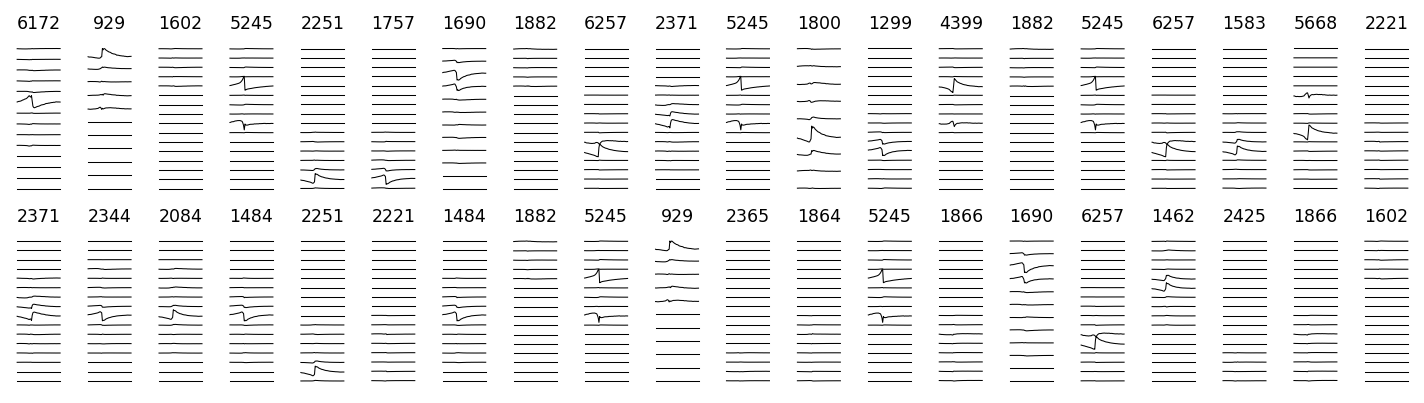

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qsttest_1_241115_151239\DW333_qsttest_1_241115_151239_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: -------------------------------

|
|
|
|
|
|
Running kilosort on qsttest_1_241115_151239
|
|
|
|
|
|


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 56/56 [00:04<00:00, 13.99it/s]
kilosort.run_kilosort: drift computed in  4.53s; total  4.64s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    30.80 %
kilosort.run_kilosort: Memory:       45.13 %     |     21.63   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   16.27 %     |      1.30   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.15 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kil

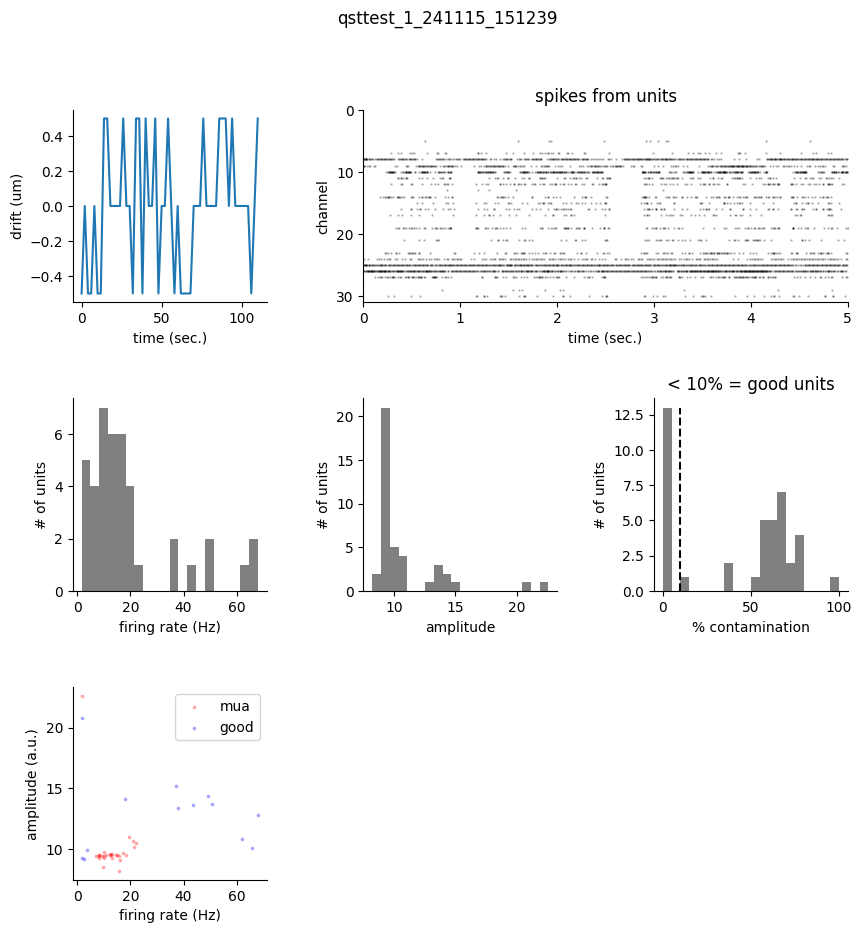

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qsttest_1_241115_151239


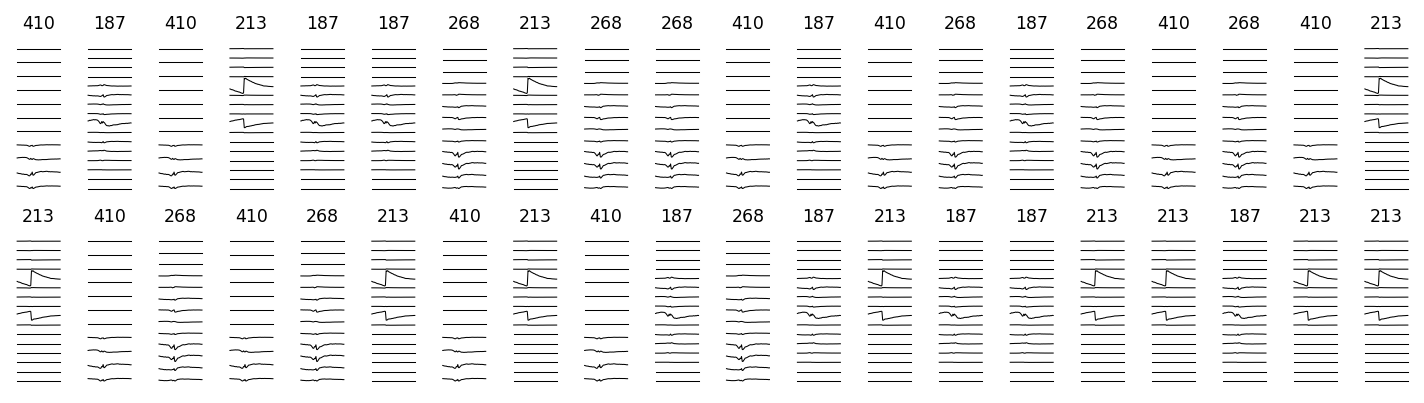

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qsttest_1_241115_151239


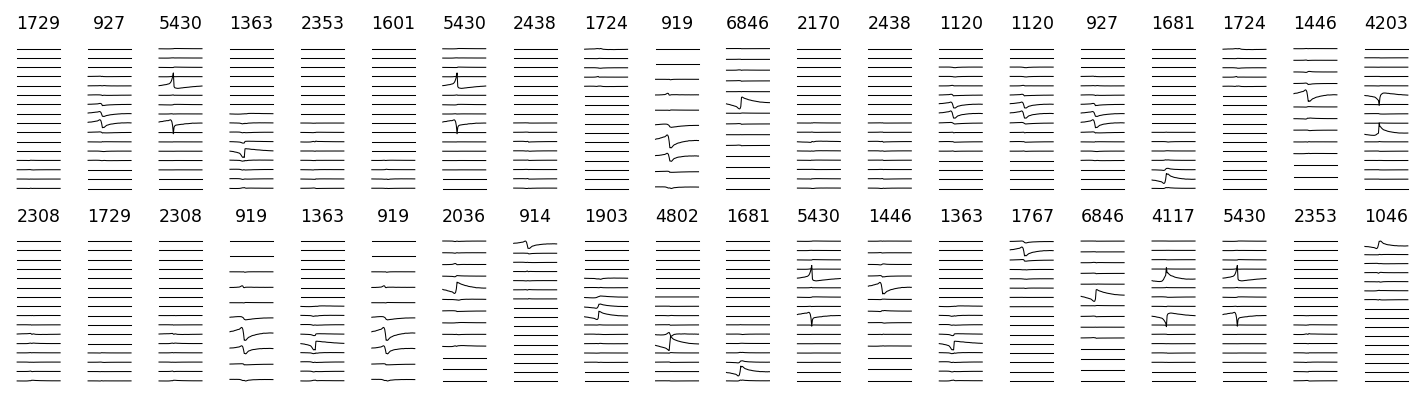

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qsttest_1_241115_151523\DW333_qsttest_1_241115_151523_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: -------------------------------

|
|
|
|
|
|
Running kilosort on qsttest_1_241115_151523
|
|
|
|
|
|


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 56/56 [00:03<00:00, 14.50it/s]
kilosort.run_kilosort: drift computed in  4.38s; total  4.48s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    31.20 %
kilosort.run_kilosort: Memory:       45.30 %     |     21.71   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   16.27 %     |      1.30   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.15 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kil

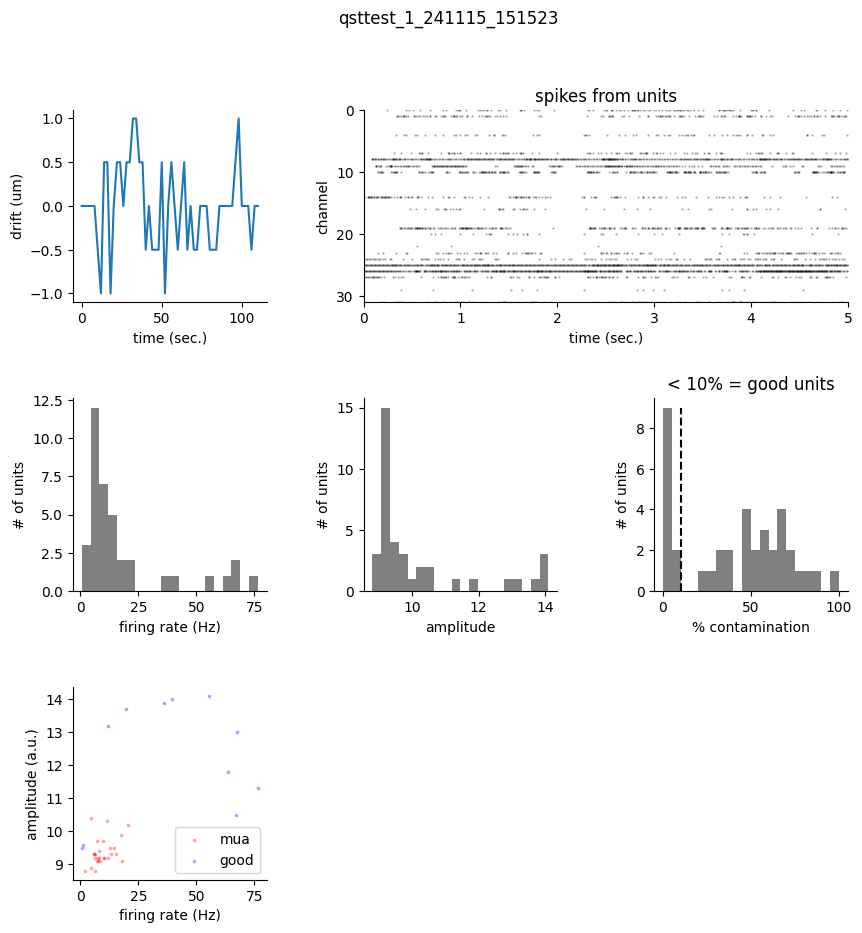

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qsttest_1_241115_151523


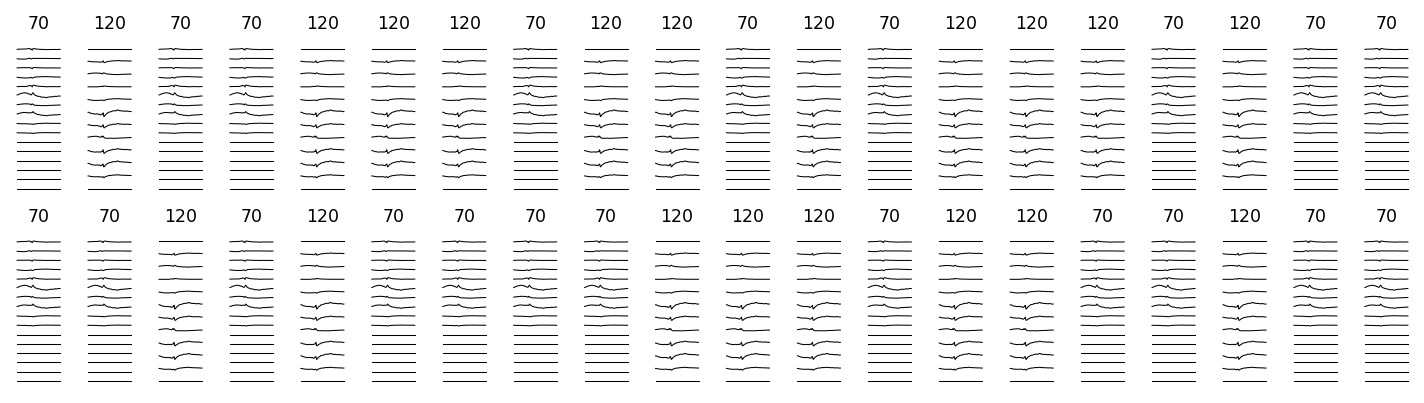

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qsttest_1_241115_151523


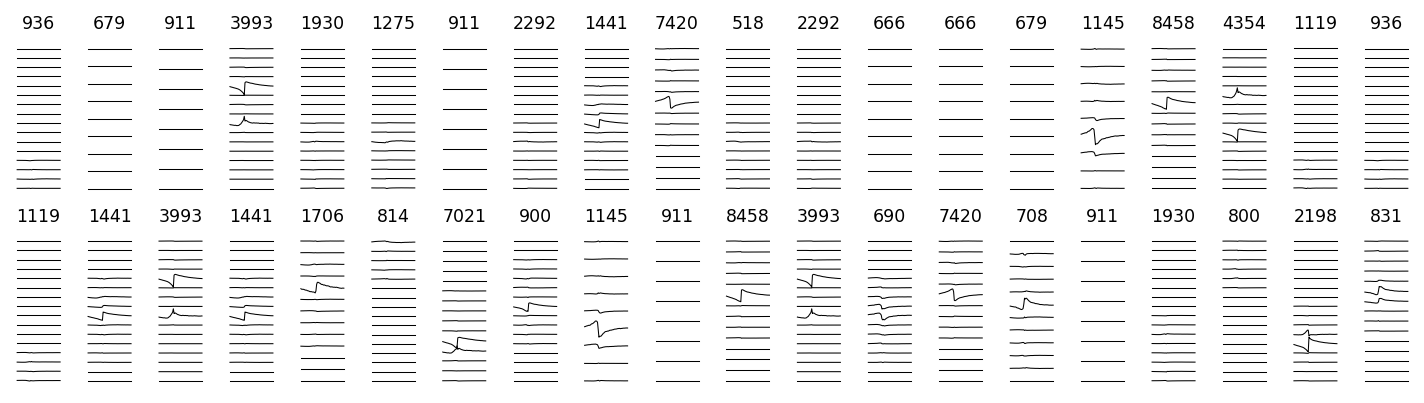

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qst_1_241115_152031\DW333_qst_1_241115_152031_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ---------------------------------------

|
|
|
|
|
|
Running kilosort on qst_1_241115_152031
|
|
|
|
|
|


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 56/56 [00:04<00:00, 13.98it/s]
kilosort.run_kilosort: drift computed in  4.58s; total  4.70s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    40.50 %
kilosort.run_kilosort: Memory:       45.45 %     |     21.79   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   16.27 %     |      1.30   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.15 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kil

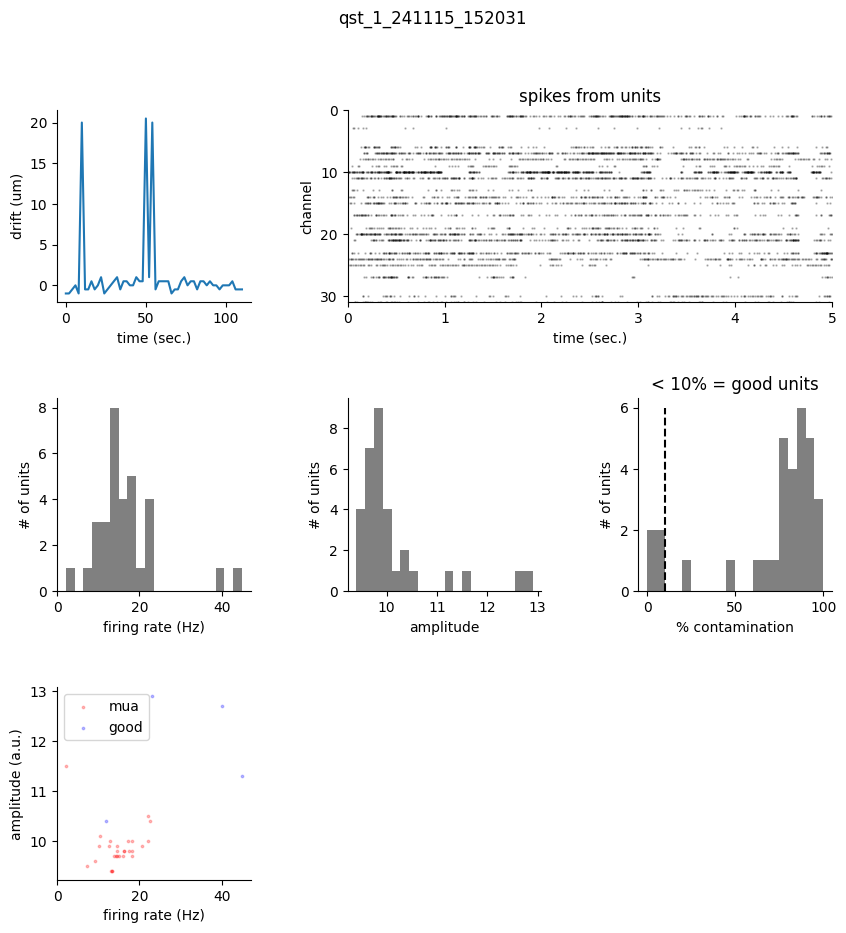

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qst_1_241115_152031


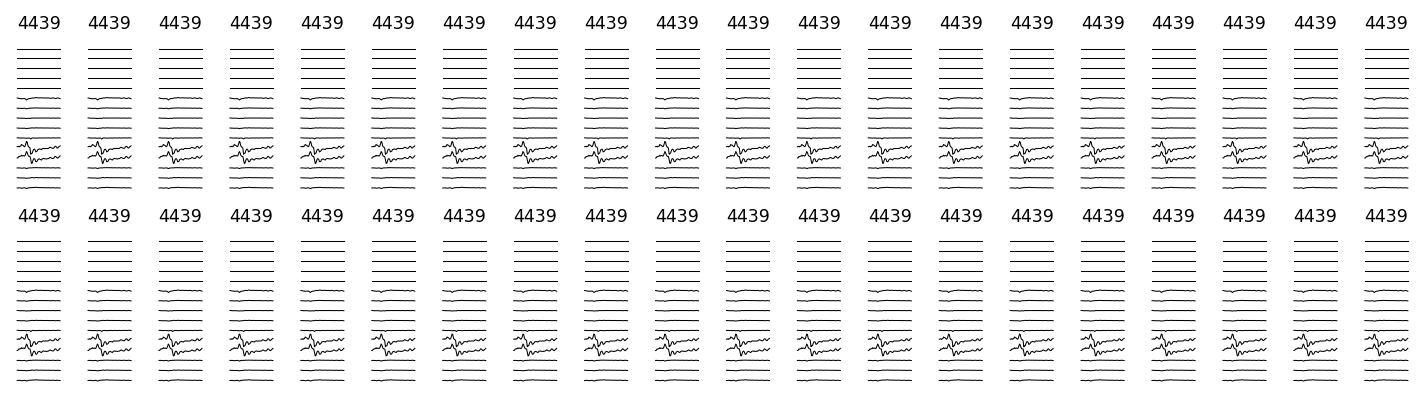

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qst_1_241115_152031


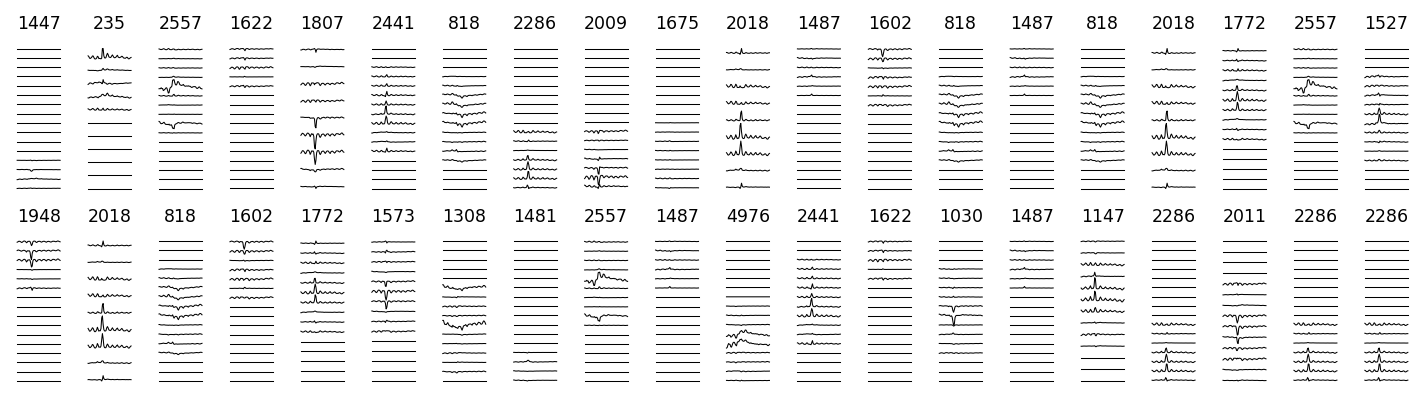

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qst_1_241115_152346\DW333_qst_1_241115_152346_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ---------------------------------------

|
|
|
|
|
|
Running kilosort on qst_1_241115_152346
|
|
|
|
|
|


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 56/56 [00:03<00:00, 14.24it/s]
kilosort.run_kilosort: drift computed in  4.43s; total  4.53s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    20.30 %
kilosort.run_kilosort: Memory:       45.32 %     |     21.72   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   16.27 %     |      1.30   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.15 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kil

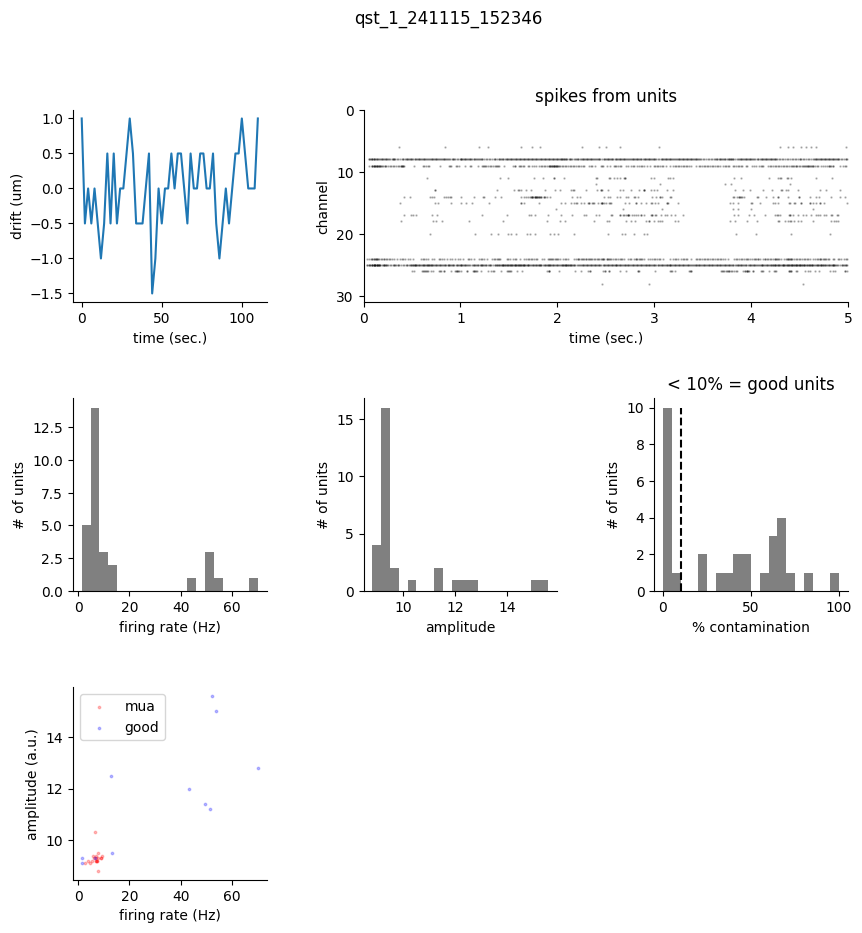

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qst_1_241115_152346


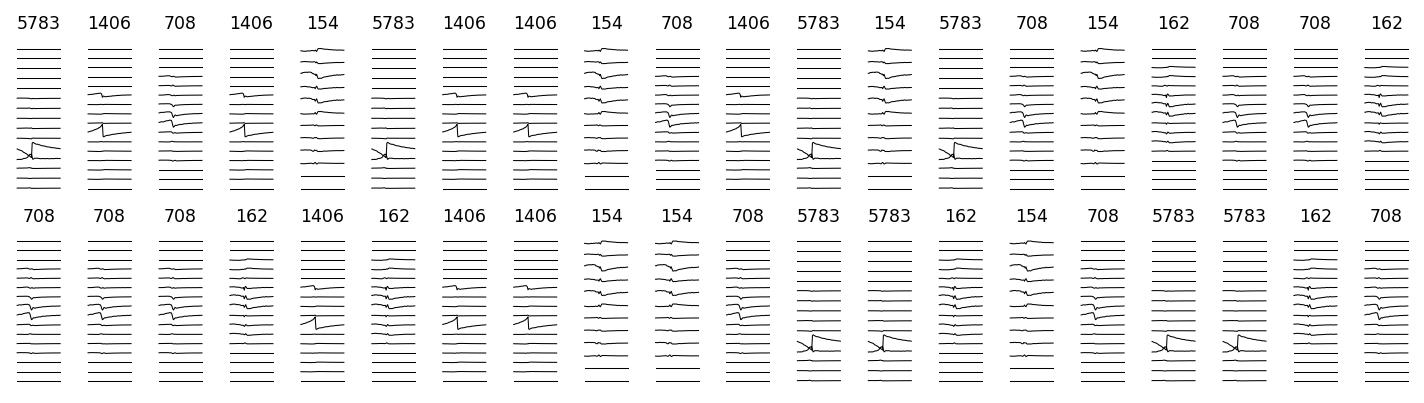

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qst_1_241115_152346


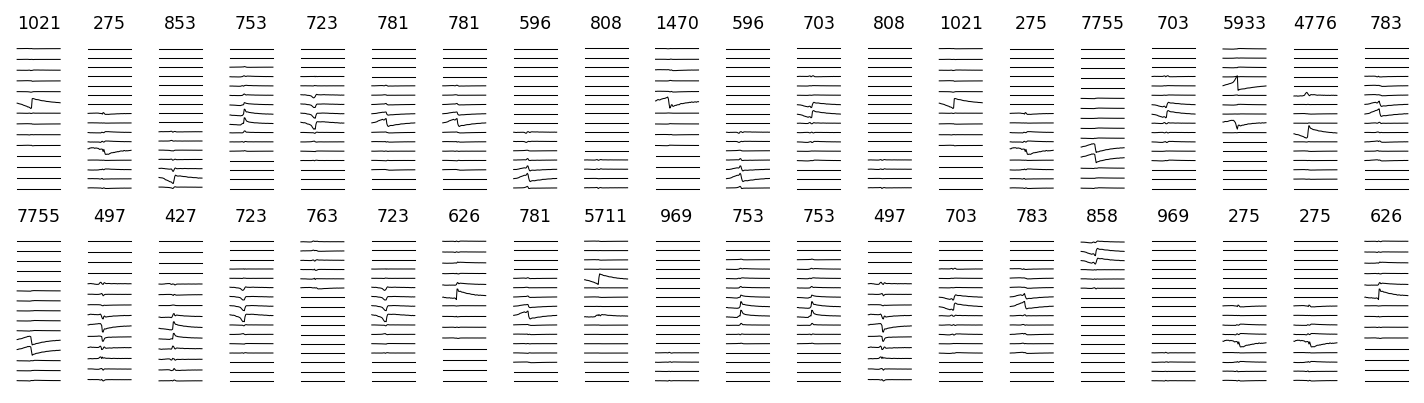

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\qst_1_241115_152800\DW333_qst_1_241115_152800_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ---------------------------------------

|
|
|
|
|
|
Running kilosort on qst_1_241115_152800
|
|
|
|
|
|


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 56/56 [00:04<00:00, 13.95it/s]
kilosort.run_kilosort: drift computed in  4.53s; total  4.64s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    23.80 %
kilosort.run_kilosort: Memory:       44.86 %     |     21.50   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   16.27 %     |      1.30   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.15 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kil

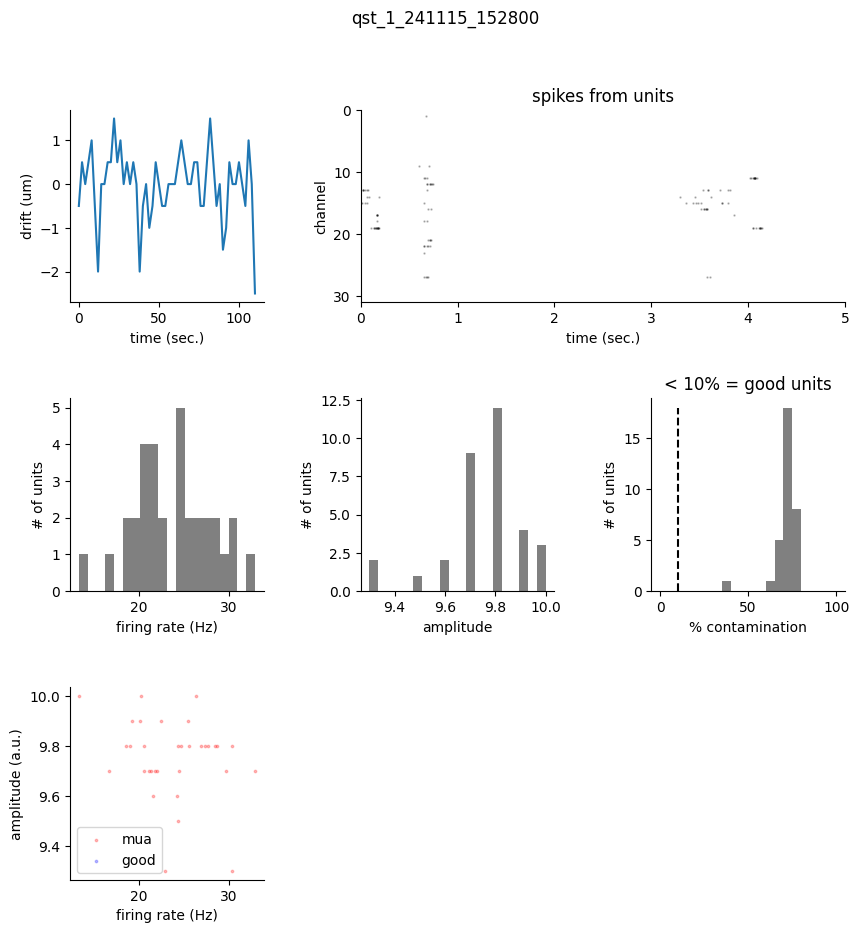

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\VF_DRG_1_241115_145120\DW333_VF_DRG_1_241115_145120_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ---------------------------------

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
qst_1_241115_152800
ERROR: could not plot qst_1_241115_152800
|
|
|
|
|
|
Running kilosort on VF_DRG_1_241115_145120
|
|
|
|
|
|


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 56/56 [00:04<00:00, 13.42it/s]
kilosort.run_kilosort: drift computed in  4.66s; total  4.79s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    21.80 %
kilosort.run_kilosort: Memory:       44.84 %     |     21.49   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   17.00 %     |      1.36   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.15 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kil

<Figure size 1800x450 with 0 Axes>

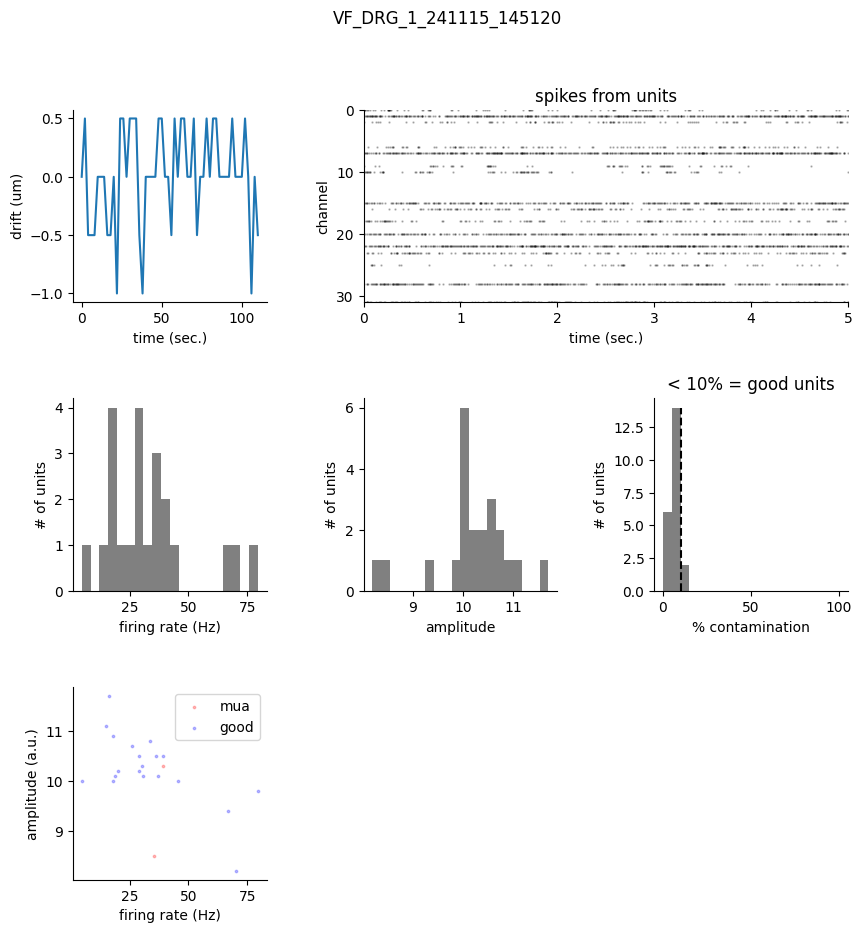

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
VF_DRG_1_241115_145120


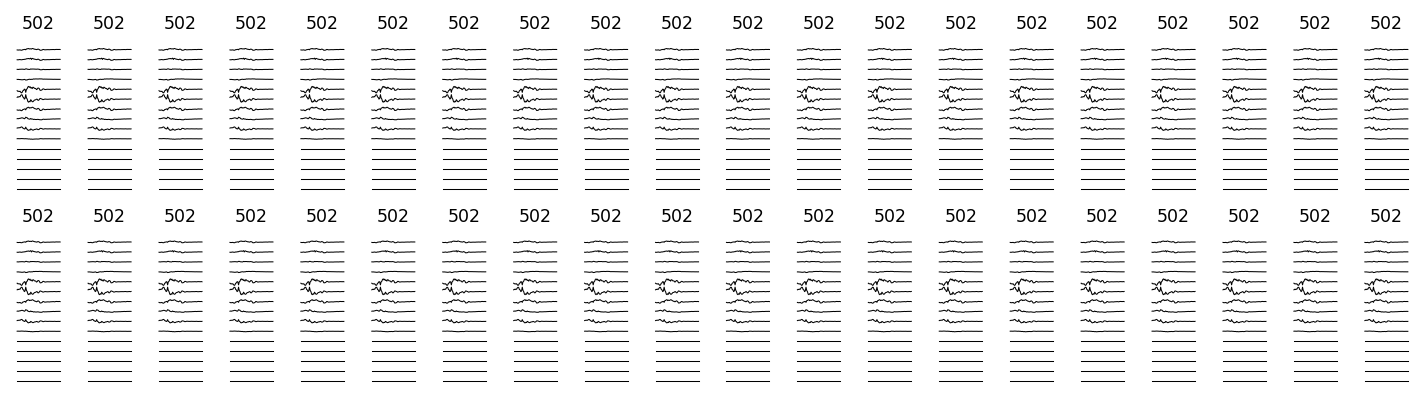

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
VF_DRG_1_241115_145120


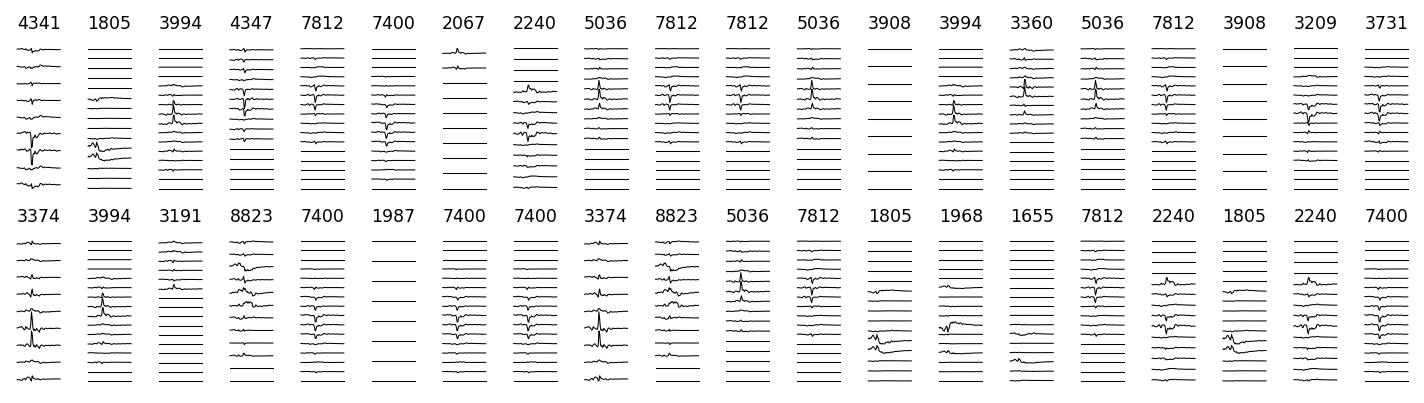

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\VF_DRG_1_241115_145435\DW333_VF_DRG_1_241115_145435_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ---------------------------------

|
|
|
|
|
|
Running kilosort on VF_DRG_1_241115_145435
|
|
|
|
|
|


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 56/56 [00:04<00:00, 13.99it/s]
kilosort.run_kilosort: drift computed in  4.50s; total  4.61s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    29.20 %
kilosort.run_kilosort: Memory:       44.91 %     |     21.53   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   17.00 %     |      1.36   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.15 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kil

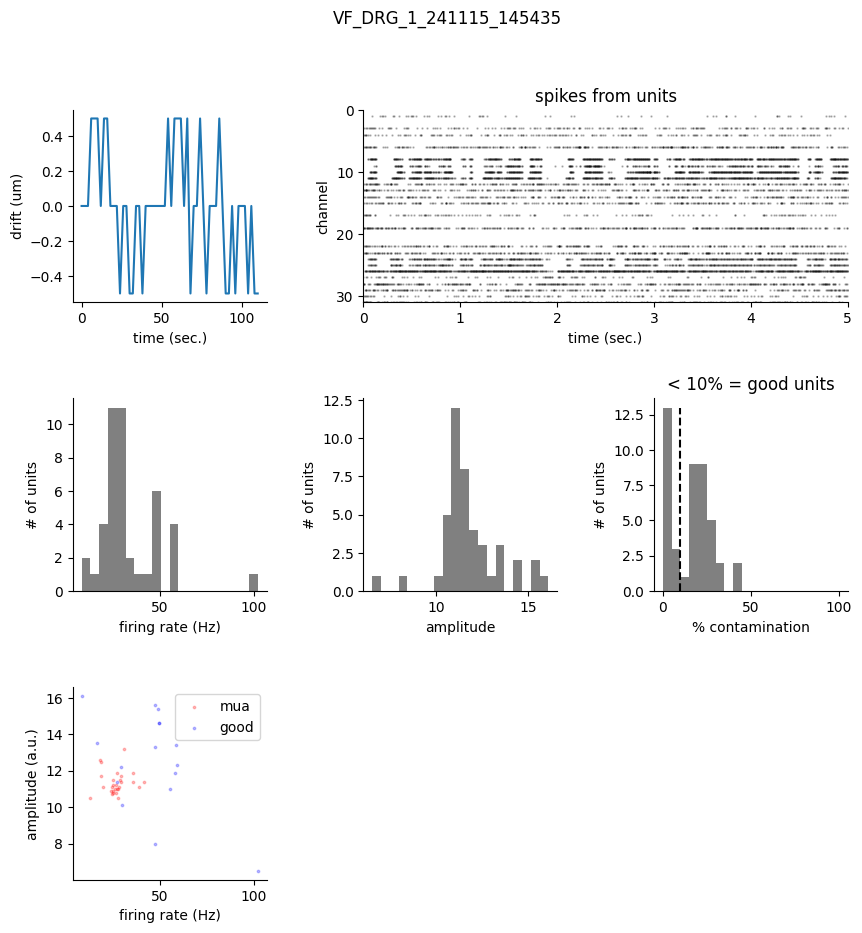

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
VF_DRG_1_241115_145435


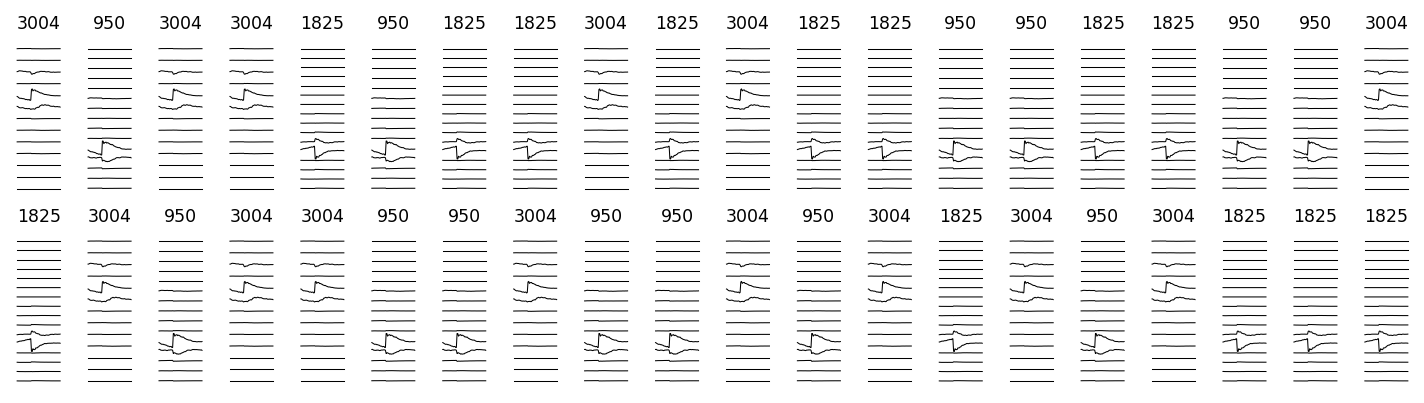

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
VF_DRG_1_241115_145435


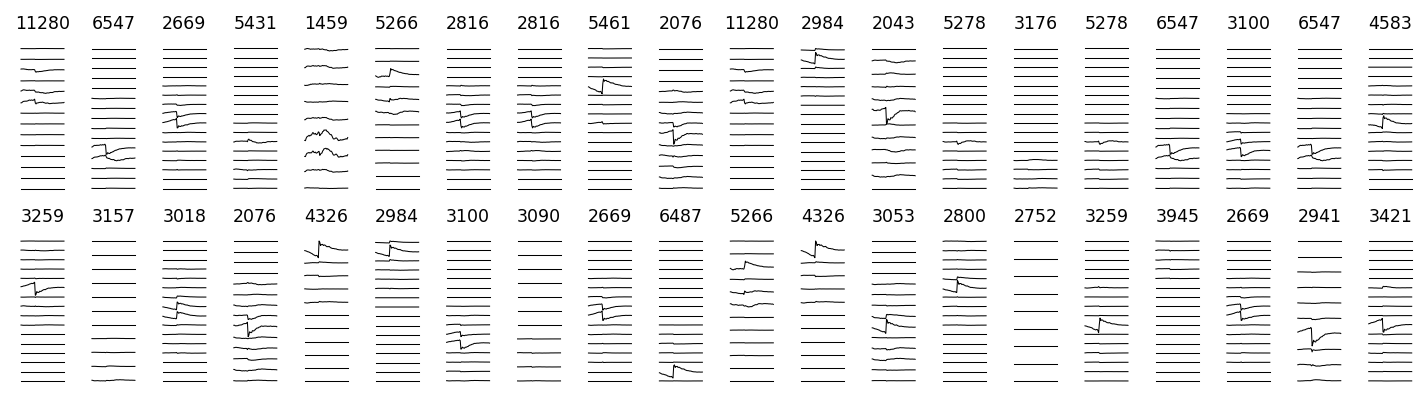

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\VF_DRG_1_241115_145739\DW333_VF_DRG_1_241115_145739_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ---------------------------------

|
|
|
|
|
|
Running kilosort on VF_DRG_1_241115_145739
|
|
|
|
|
|


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 56/56 [00:04<00:00, 13.85it/s]
kilosort.run_kilosort: drift computed in  4.58s; total  4.69s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    42.40 %
kilosort.run_kilosort: Memory:       44.86 %     |     21.50   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   17.00 %     |      1.36   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.15 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kil

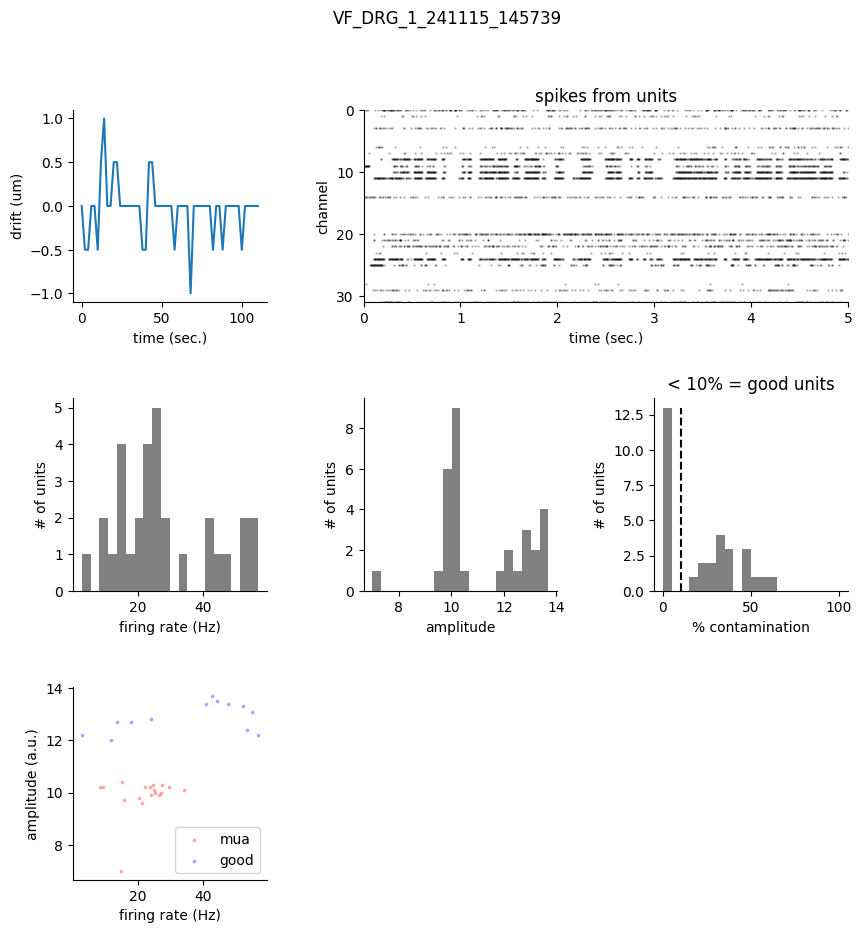

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
VF_DRG_1_241115_145739


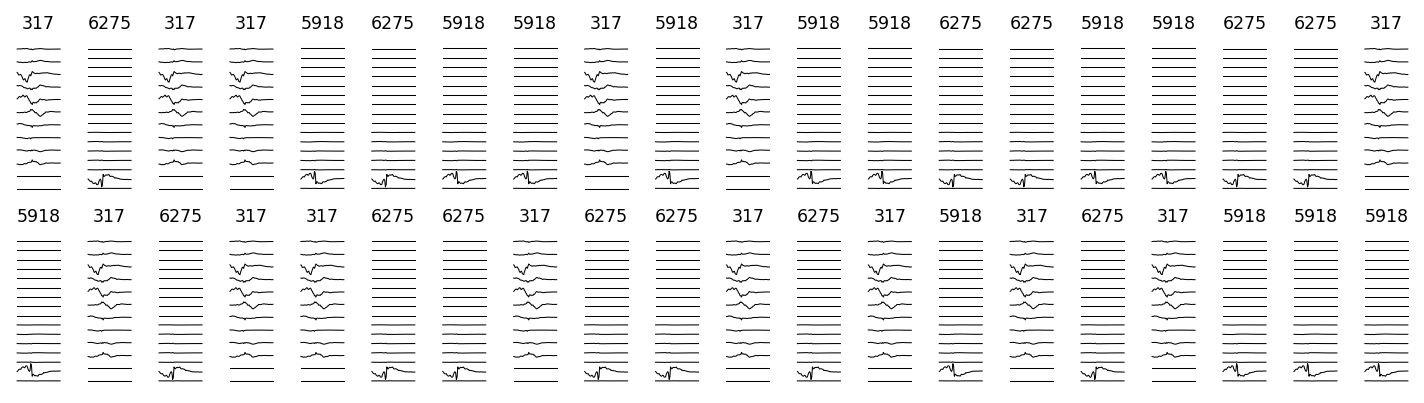

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
VF_DRG_1_241115_145739


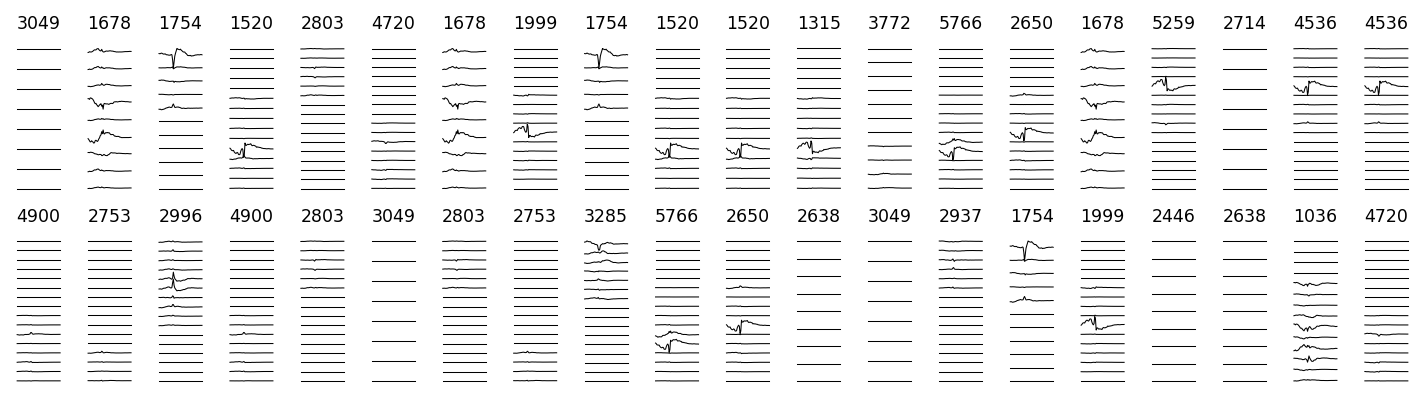

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\VF_DRG_4_241115_153512\DW333_VF_DRG_4_241115_153512_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ---------------------------------

|
|
|
|
|
|
Running kilosort on VF_DRG_4_241115_153512
|
|
|
|
|
|


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 56/56 [00:04<00:00, 13.96it/s]
kilosort.run_kilosort: drift computed in  4.51s; total  4.61s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    22.70 %
kilosort.run_kilosort: Memory:       44.85 %     |     21.50   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   17.00 %     |      1.36   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.15 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kil

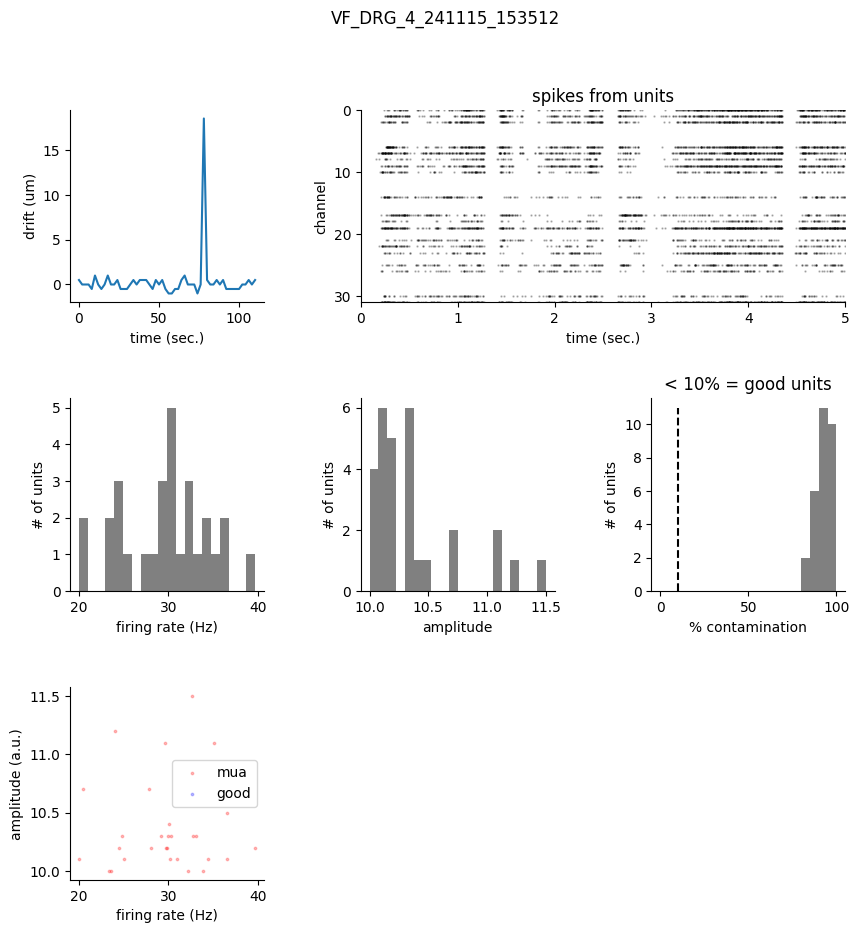

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit
VF_DRG_4_241115_153512
ERROR: could not plot VF_DRG_4_241115_153512


<Figure size 1800x450 with 0 Axes>

In [7]:
analysis.run_spinalcord_kilosort()